In [16]:
import numpy as np
import torch as th
import torch.nn as nn
from torch.distributions import Normal
import matplotlib.pyplot as plt

In [17]:
class u_t(nn.Module):
    def __init__(s, xdim=2, udim=1):
        super().__init__()
        """
        Build two layer neural network
        We will assume that the variance of the stochastic
        controller is a constant, to the network simply
        outputs the mean. We will do a hack to code up the constraint
        on the magnitude of the control input. We use a tanh nonlinearity
        to ensure that the output of the network is always between [-1,1]
        and then add a noise to it. While the final sampled control may be larger
        than the constraint we desire [-1,1], this is a quick cheap way to enforce the constraint.
        """
        s.m = nn.Sequential(
            nn.Linear(xdim, 8),
            nn.ReLU(True),
            nn.Linear(8, udim),
            nn.Tanh(),
        )
        s.std = 1

    def forward(s, x, u=None):
        """
        This is a PyTorch function that runs the network
        on a state x to output a control u. We will also output
        the log probability log u_theta(u | x) because we want to take
        the gradient of this quantity with respect to the parameters
        """
        # Mean control
        mu = s.m(x)
        # Build u_theta(cdot | x)
        n = Normal(mu, s.std)
        # Sample a u if we are simulating the system, use the argument if
        # we are calculating the policy gradient
        if u is None:
            u = n.rsample()
        logp = n.log_prob(u) # Returns the log of the probability density/mass function evaluated at value.
        return u, logp

In [18]:
def rollout(policy):
    """
    Sample a trajectory based on the policy 
    We will use the control u_theta(x_t) to take the control action at each
    timestep. You can use simple Euler integration to simulate the ODE forward
    for T = 200 timesteps with discretization dt=0.05.
    At each time-step, you should record the state x, control u, and the reward r.
    OUTPUT: Dictionary
        'x': state of all the timesteps, tensor
        'u': control input
        'r': reward of each time step
        'R': Return
    """
    m = 2; l = 1; b = 0.1; g = 9.8
    gamma = 0.99
    get_rew = lambda z, zdot, u: -0.5 * ((np.pi - z) ** 2 + zdot ** 2 + 0.01 * u ** 2)

    xs = [np.zeros(2)]; us = []; rs= []
    dt = 0.05
    for t in np.arange(0, 10, dt):
        # The interface between PyTorch and numpy becomes a bit funny
        # but all that this line is doing is that it is running u(x) to get
        # a control for one state x
        u = policy(th.from_numpy(xs[-1]).view(1, -1).float())[0].detach().numpy().squeeze().item()

        z, zdot = xs[-1][0], xs[-1][1]
        zp = z + zdot * dt
        zdotp = zdot + dt * (u - m * g * l * np.sin(z) - b * zdot) / m / l ** 2

        rs.append(get_rew(z, zdot, u))
        us.append(u)
        xs.append(np.array([zp, zdotp]))

    # R is the discounted cumulative reward
    R = sum([rr * gamma ** k for k, rr in enumerate(rs)])
    return {'x': th.tensor(xs[:-1]).float(),
            'u': th.tensor(us).float(),
            'r': th.tensor(rs).float(),
            'R': R}

In [19]:
def example_train():
    """
    The following code shows how to compute the policy gradient and update
    the weights of the neural network using one trajectory.
    """
    policy = u_t(xdim=2, udim=1)
    optim = th.optim.Adam(policy.parameters(), lr=1e-3)

    '''
    1. Get a trajectory
    '''
    t = rollout(policy)

    """"
    2. We now want to calculate grad log u_theta(u | x), so
    we will feed all the states from the trajectory again into the network
    and this time we are interested in the log-probabilities. The following
    code shows how to update the weights of the model using one trajectory
    """
    logp = policy(t['x'].view(-1,2), t['u'].view(-1,1))[1] # log probability of taking u given x
    f = -(t['R'] * logp).mean() # loss function: maximize reward = minimize negetive reward
    
    # .zero_grad() is a PyTorch peculiarity that clears the backpropagation
    # gradient buffer before calling the next .backward()
    policy.zero_grad()
    # .backward() computes the gradient of the policy gradient objective with respect
    # to the parameters of the policy and stores it in the gradient buffer
    f.backward()
    # .step() updates the weights of the policy using the computed gradient
    optim.step()

In [20]:
def train():
    """
    TODO: XXXXXXXXXXXX
    This is very similar to example_train() above. You should sample
    multiple trajectory at each iteration and run the training for about 1000
    iterations. You should track the average value of the return across multiple
    trajectories and plot it as a function of the number of iterations.
    """
    policy = u_t(xdim=2, udim=1)
    optim = th.optim.Adam(policy.parameters(), lr=1e-3)

    # train the policy network
    num_iteration = 1000
    R_iteration = []
    for i in range(num_iteration):
        # get 100 trajectories
        num_trajectories = 10
        R_multiple_traj = []
        t_multi_traj = []
        for j in range(num_trajectories):
            t = rollout(policy)
            R = t['R']
            R_multiple_traj.append(R)
            t_multi_traj.append(t)
        # compute baseline
        b = sum(R_multiple_traj)/num_trajectories
        R_iteration.append(b)
        # compute average loss of multiple traj
        for k in range(num_trajectories):
            t = t_multi_traj[k]
            # compute prediction: log probability of 
            logp = policy(t['x'].view(-1,2), t['u'].view(-1,1))[1]
            if k == 0:
                loss = -((R_multiple_traj[k]-b) * logp).mean()
            else: 
                loss += -((R_multiple_traj[k]-b) * logp).mean()
                
        mean_loss = loss/num_trajectories
        # .zero_grad() is a PyTorch peculiarity that clears the backpropagation
        # gradient buffer before calling the next .backward()
        policy.zero_grad()
        # .backward() computes the gradient of the policy gradient objective with respect
        # to the parameters of the policy and stores it in the gradient buffer
        mean_loss.backward()
        # .step() updates the weights of the policy using the computed gradient
        optim.step()

    return R_iteration

In [21]:
def plot_R_t(R_multiple_traj):
    # R_multiTraj_np = th.cat(R_multiple_traj,0).numpy()

    plt.plot(np.array(R_multiple_traj).flatten())
    plt.xlabel('Iteration')
    plt.ylabel('Return')
    plt.savefig('p1')


In [22]:
R_multiTraj = train()


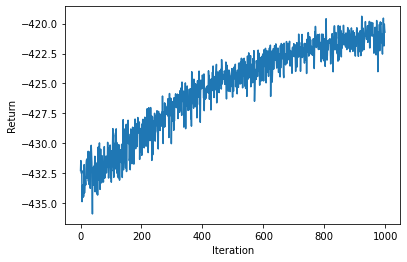

In [24]:
plot_R_t(R_multiTraj)